In [330]:
import pandas as pd
import plotly.express as px
from copy import copy
from scipy import stats
import math
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
from sklearn.linear_model import LinearRegression
from tensorflow import keras
import seaborn as sns
color_pal = sns.color_palette()
from sklearn.metrics import mean_squared_error
import xgboost as xgb
plt.style.use('fivethirtyeight')

In [331]:
df=pd.read_excel("apple.xlsx")
df

,Symbol,Sample Time,Open,High,Low,Close,Volume
0,AAPL,2000-01-03 14:30:00,0.936384,1.004464,0.907924,0.999442,535796800
1,AAPL,2000-01-04 14:30:00,0.966518,0.987723,0.903460,0.915179,512377600
2,AAPL,2000-01-05 14:30:00,0.926339,0.987165,0.919643,0.928571,778321600
3,AAPL,2000-01-06 14:30:00,0.947545,0.955357,0.848214,0.848214,767972800
4,AAPL,2000-01-07 14:30:00,0.861607,0.901786,0.852679,0.888393,460734400
...,...,...,...,...,...,...,...
5279,AAPL,2020-12-24 14:30:00,131.320007,133.460007,131.100006,131.970001,54930100
5280,AAPL,2020-12-28 14:30:00,133.990005,137.339996,133.509995,136.690002,124486200
5281,AAPL,2020-12-29 14:30:00,138.050003,138.789993,134.339996,134.869995,121047300
5282,AAPL,2020-12-30 14:30:00,135.580002,135.990005,133.399994,133.720001,96452100


In [332]:
df=df.drop(['Symbol'], axis=1)

In [333]:
df=df.set_index('Sample Time')


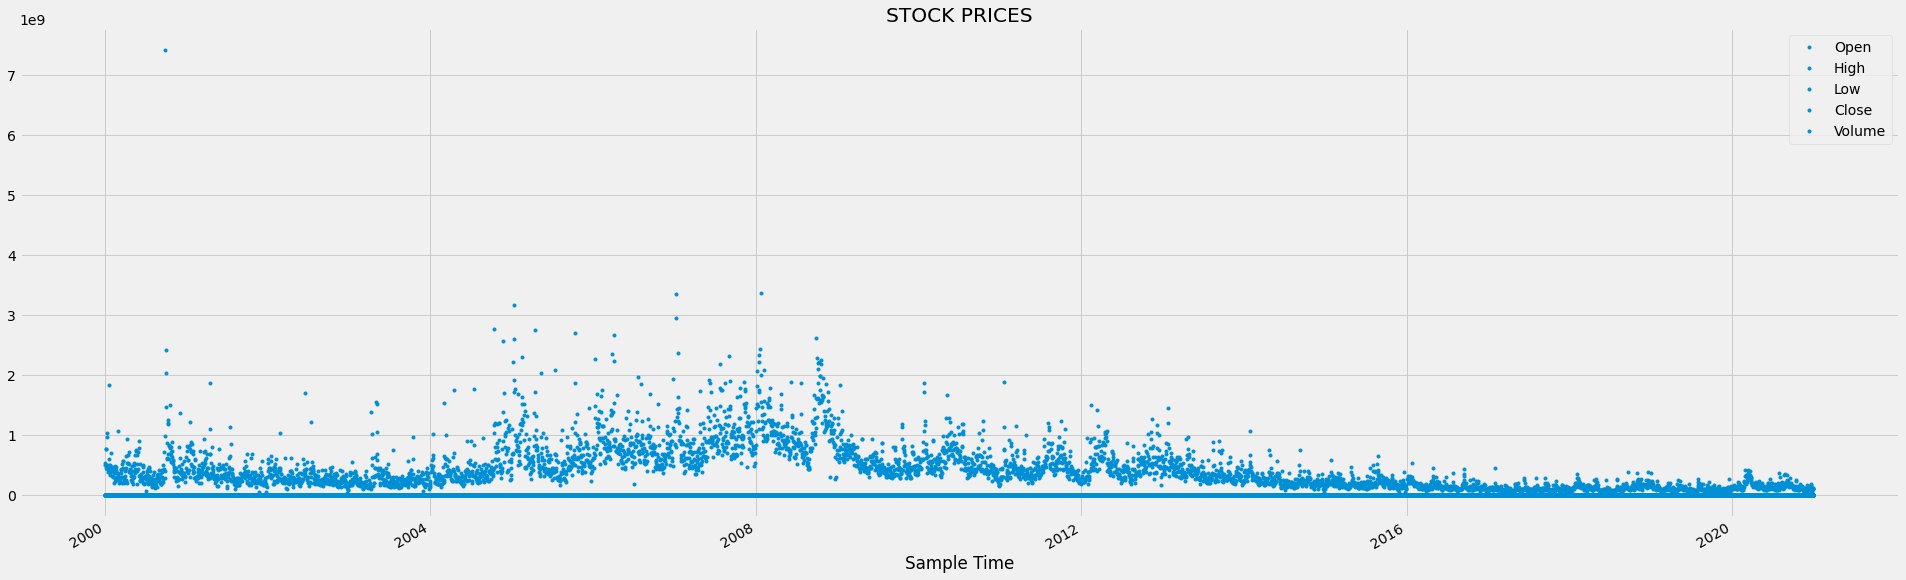

In [334]:
df.plot(style='.',
        figsize=(30, 10),
        color=color_pal[0],
        title='STOCK PRICES')
plt.show()


<AxesSubplot:ylabel='Frequency'>

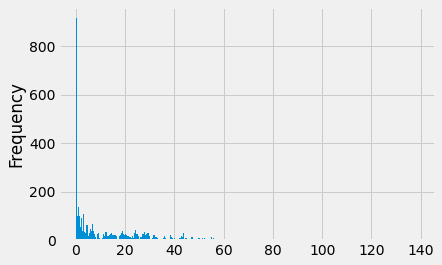

In [335]:
df['High'].plot(kind='hist', bins=500)

In [336]:
train=df.loc[df.index<'2018-01-01']
test=df.loc[df.index>='2018-01-01']

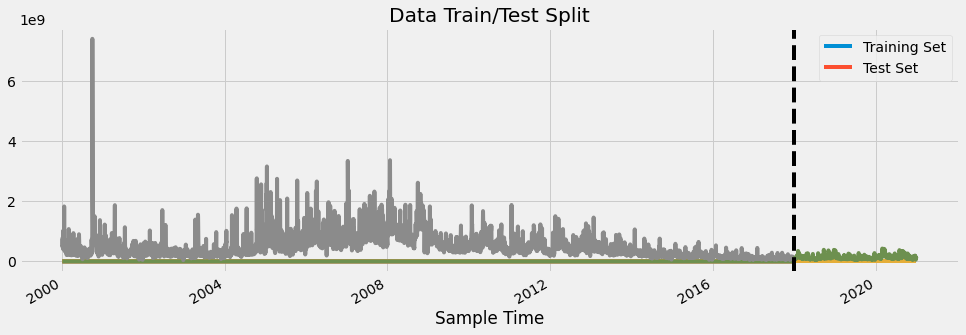

In [337]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2018', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

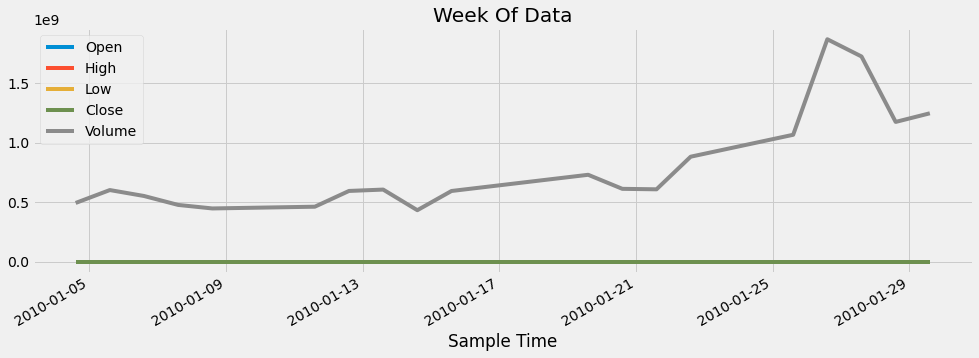

In [338]:
df.loc[(df.index > '2010-01-01') & (df.index < '2010-01-31')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [339]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [340]:
df=create_features(df)
df

,Open,High,Low,Close,Volume,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Sample Time,,,,,,,,,,,,,
2000-01-03 14:30:00,0.936384,1.004464,0.907924,0.999442,535796800,14,0,1,1,2000,3,3,1
2000-01-04 14:30:00,0.966518,0.987723,0.903460,0.915179,512377600,14,1,1,1,2000,4,4,1
2000-01-05 14:30:00,0.926339,0.987165,0.919643,0.928571,778321600,14,2,1,1,2000,5,5,1
2000-01-06 14:30:00,0.947545,0.955357,0.848214,0.848214,767972800,14,3,1,1,2000,6,6,1
2000-01-07 14:30:00,0.861607,0.901786,0.852679,0.888393,460734400,14,4,1,1,2000,7,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24 14:30:00,131.320007,133.460007,131.100006,131.970001,54930100,14,3,4,12,2020,359,24,52
2020-12-28 14:30:00,133.990005,137.339996,133.509995,136.690002,124486200,14,0,4,12,2020,363,28,53
2020-12-29 14:30:00,138.050003,138.789993,134.339996,134.869995,121047300,14,1,4,12,2020,364,29,53


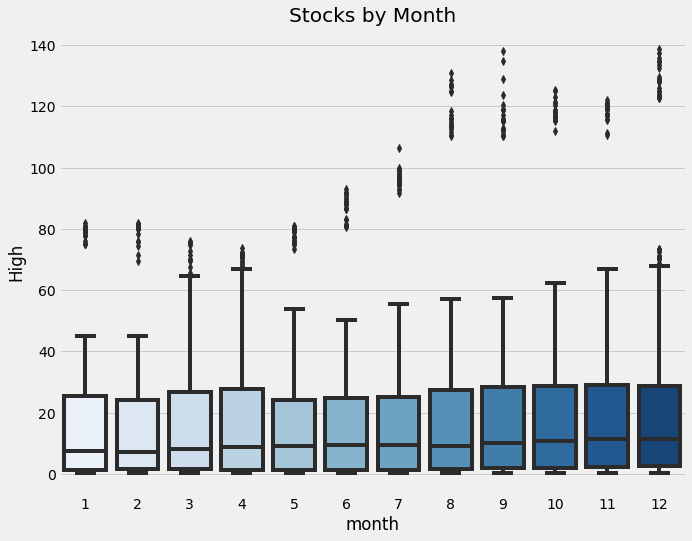

In [341]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='High', palette='Blues')
ax.set_title('Stocks by Month')
plt.show()

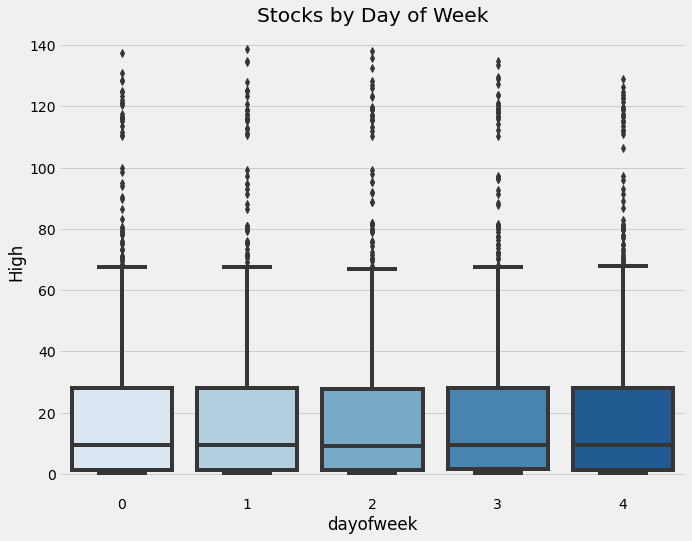

In [342]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='High', palette='Blues')
ax.set_title('Stocks by Day of Week')
plt.show()

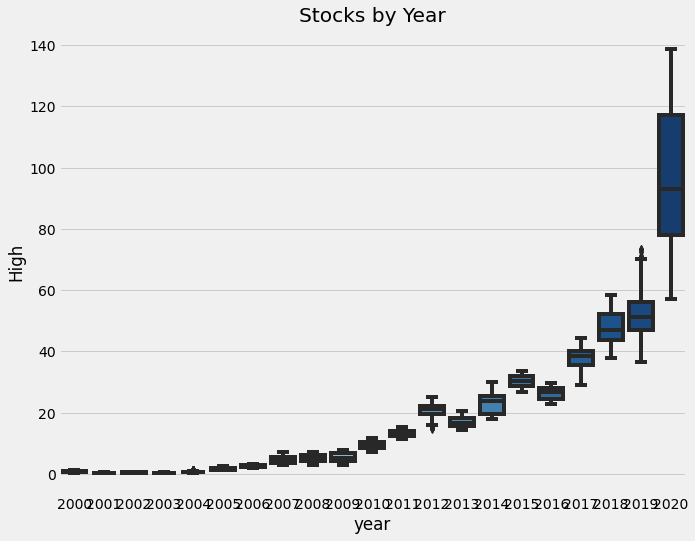

In [343]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='year', y='High', palette='Blues')
ax.set_title('Stocks by Year')
plt.show()

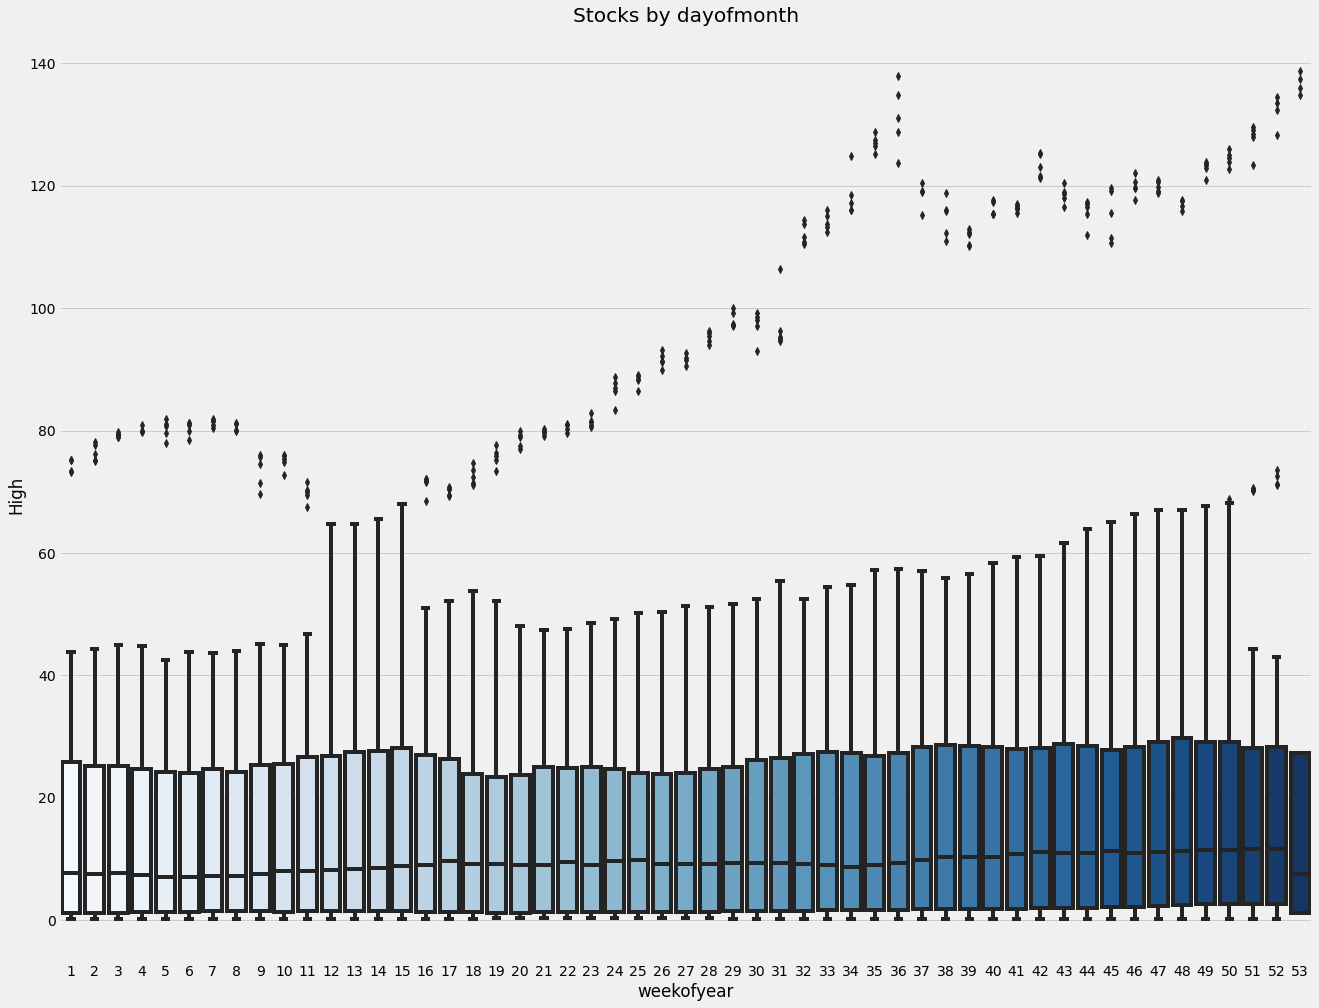

In [344]:
fig, ax = plt.subplots(figsize=(20, 16))
sns.boxplot(data=df, x='weekofyear', y='High', palette='Blues')
ax.set_title('Stocks by dayofmonth')
plt.show()

In [345]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year','Open','Volume','Low','Close']
TARGET = 'High'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [346]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[01:22:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15.67119	validation_1-rmse:69.87267
[100]	validation_0-rmse:5.80856	validation_1-rmse:47.71889
[200]	validation_0-rmse:2.15917	validation_1-rmse:39.80533
[300]	validation_0-rmse:0.80706	validation_1-rmse:36.72986
[400]	validation_0-rmse:0.30831	validation_1-rmse:35.43494
[500]	validation_0-rmse:0.13087	validation_1-rmse:34.88199
[600]	validation_0-rmse:0.07636	validation_1-rmse:34.64017
[700]	validation_0-rmse:0.06098	validation_1-rmse:34.54505
[800]	validation_0-rmse:0.05632	validation_1-rmse:34.47235
[900]	validation_0-rmse:0.05461	validation_1-rmse:34.42103
[999]	validation_0-rmse:0.05326	validation_1-rmse:34.39714


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

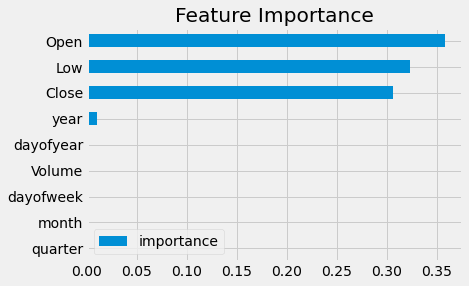

In [347]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

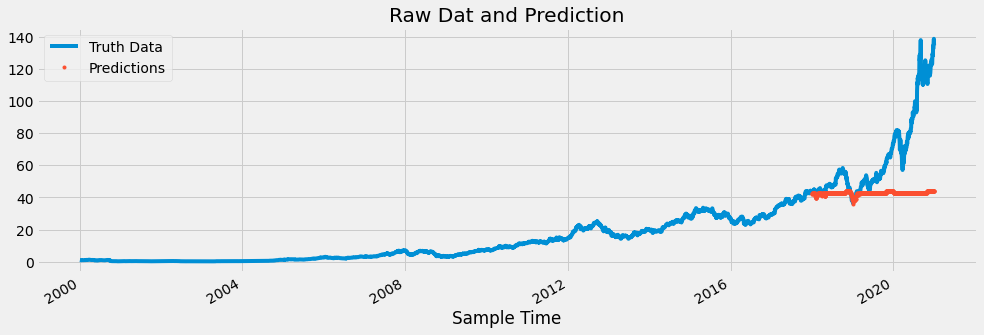

In [348]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['High']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [349]:
score = np.sqrt(mean_squared_error(test['High'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 34.40


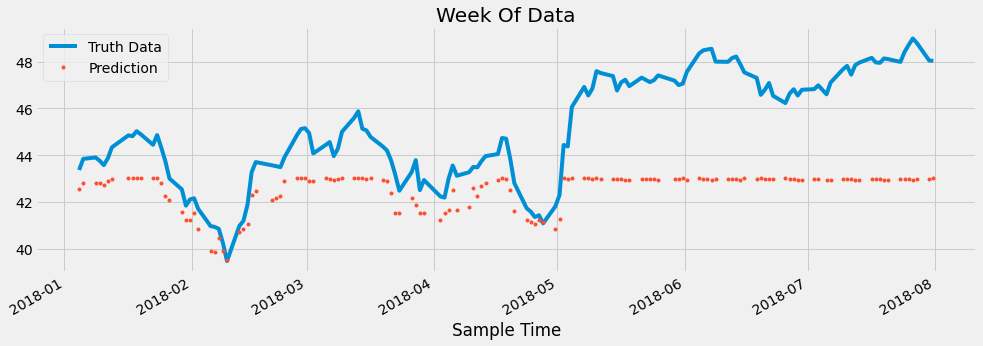

In [350]:
ax = df.loc[(df.index > '2018-01-04') & (df.index < '2018-08-01')]['High'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '2018-01-04') & (df.index < '2018-08-01')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [351]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2020-09-02    94.941597
2020-12-29    94.719688
2020-12-28    93.268745
2020-12-30    91.964413
2020-09-01    91.768574
2020-12-31    90.715481
2020-12-22    90.339699
2020-12-24    89.457214
2020-12-23    88.426495
2020-08-31    87.954376
Name: error, dtype: float64

In [352]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2018-12-10    0.004513
2019-01-28    0.004799
2019-01-24    0.014988
2019-01-18    0.026299
2019-01-10    0.034477
2018-02-09    0.051373
2019-01-11    0.057381
2019-01-22    0.066757
2018-04-27    0.070572
2018-12-17    0.084610
Name: error, dtype: float64